In [1]:
# packages and libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from imutils import paths
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM,GRU, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import backend as K

In [2]:
def getUnreadableCount(df):
    return (df['IDENTITY'] == 'UNREADABLE').sum();

def getLowercaseCount(df):
    return (df['IDENTITY'].str.islower()).sum();

def getDigitCount(df):
    return (df['IDENTITY'].str.isdigit()).sum();
  
def removeUnreadableEntries(df):
    is_unreadable = df['IDENTITY'] != 'UNREADABLE';
    df = df[is_unreadable];
    return df;

def removeDigitEntries(df):
    is_digit = df['IDENTITY'].str.isdigit();
    df = df[is_digit];
    return df;

def cleanDataSet(df):
    empty_count = df.isnull().sum().sum();      # 565 for train, 78 for validation
    if(empty_count):
        df.dropna(inplace=True);
    unreadable_count = getUnreadableCount(df);  # 102 for train, 12 for validation
    if(unreadable_count):
        df = removeUnreadableEntries(df);
    digit_count = getDigitCount(df);            # 0 for train, 0 for validation
    if(digit_count):
        df = removeDigitEntries(df);
    lowercase_count = getLowercaseCount(df);    # 13 for train, 2 for validation
    if(lowercase_count):
        # Names in the pictures are all uppercase, we have to make our data uppercase
        df.loc[:, 'IDENTITY'] = df['IDENTITY'].apply(lambda x: x.upper());
    notpicture_count = df[~df["FILENAME"].str.endswith('.jpg')].sum().sum().astype(int);
    if(notpicture_count):                       # 0 for train, 0 for validation
         df = df[df["FILENAME"].str.contains('.jpg')];
    return df;

def num_to_char(num): 
    label = ""
    for ch in num:
        if ch == -1:
            break
        label+=alphabet_characters[ch]        
    return label

def ctc_loss_function(args):  
    y_pred, y_true, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [3]:
train_size = 50000
valid_size= 10000
alphabet_characters = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
num_of_characters = len(alphabet_characters) + 1
num_of_timestamps = 64

In [4]:
training_written_df = pd.read_csv('D:/Thirumalai/32053/RCNN&GRU/written_name_train_v2.csv')
validation_written_df = pd.read_csv('D:/Thirumalai/32053/RCNN&GRU/written_name_validation_v2.csv')

In [5]:
training_written_df = cleanDataSet(training_written_df);
validation_written_df = cleanDataSet(validation_written_df);
    
# To make sure our indices are one behind the other
training_written_df.reset_index(inplace = True, drop=True)
validation_written_df.reset_index(inplace = True, drop=True)

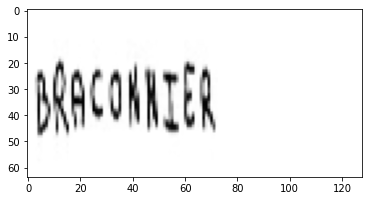

In [6]:
i = 128;
img_dir = 'D:/Thirumalai/32053/RCNN&GRU/train/'+training_written_df.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(image, (128, 64))
plt.imshow(new_img, cmap = 'gray')
plt.show()

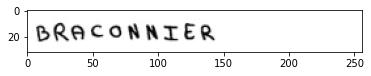

In [7]:
i = 128;
img_dir = 'D:/Thirumalai/32053/RCNN&GRU/train/'+training_written_df.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(image, (256, 32))
plt.imshow(new_img, cmap = 'gray')
plt.show()

In [11]:
valid_x = []
for i in range(valid_size):
    img_dir = 'D:/Thirumalai/32053/RCNN&GRU/validation/'+validation_written_df.loc[i, 'FILENAME']   
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    valid_x.append(image)
    
train_x = []
for j in range(train_size):
    img_dir = 'D:/Thirumalai/32053/RCNN&GRU/train/'+training_written_df.loc[j, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    train_x.append(image)

In [12]:
valid_x = np.array(valid_x).reshape(-1, 256, 32, 1)
train_x = np.array(train_x).reshape(-1, 256, 32, 1)

str_len = training_written_df["IDENTITY"].str.len().max()

In [13]:
train_y = np.ones([train_size, str_len]) * -1

train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

valid_y = np.ones([valid_size, str_len]) * -1

valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

In [14]:
for i in range(train_size):
    label = []
    for ch in training_written_df['IDENTITY'][i]:
        label.append(alphabet_characters.index(ch))
    arr = np.array(label)
    train_y[i, 0:len(training_written_df.loc[i, 'IDENTITY'])] = arr;
    train_label_len[i] = len(training_written_df.loc[i, 'IDENTITY'])


for i in range(valid_size):
    label = []
    for ch in validation_written_df['IDENTITY'][i]:
        label.append(alphabet_characters.index(ch))
    arr = np.array(label)
    valid_y[i, 0:len(validation_written_df.loc[i, 'IDENTITY'])] = arr;
    valid_label_len[i] = len(validation_written_df.loc[i, 'IDENTITY'])

In [18]:
input_data = Input(shape=(256, 32, 1))

cnn_layer = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)  
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
    
cnn_layer = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(1, 2))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)
    
cnn_layer = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(1, 1))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)

cnn_layer = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)
    
# CNN to RNN
reshaped_layer = Reshape(target_shape=((64, 1024)))(cnn_layer)
dense_layer = Dense(64, activation='relu', kernel_initializer='he_normal')(reshaped_layer)
    
## RNN
rnn_layer = Bidirectional(LSTM(256, return_sequences=True))(dense_layer)
rnn_layer = Bidirectional(LSTM(256, return_sequences=True))(rnn_layer)
    
## OUTPUT
final_dense_layer = Dense(num_of_characters, kernel_initializer='he_normal')(rnn_layer)
y_pred = Activation('softmax')(final_dense_layer)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 32, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 32, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 32, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 32, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 16, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 16, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 16, 64)       256   

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)
]

In [20]:
true_labels = Input(shape=[str_len], dtype='float32')
input_length = Input(shape=[1], dtype='int64')
label_length = Input(shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_loss_function, output_shape=(1,), name='ctc_loss')([y_pred, true_labels, input_length, label_length])
model_final = Model(inputs=[input_data, true_labels, input_length, label_length], outputs=ctc_loss)

In [21]:
model_final.compile(loss={'ctc_loss' : lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

In [22]:
history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=3, batch_size=64, callbacks=my_callbacks)

Epoch 1/3
782/782 [==============================] - 5706s 7s/step - loss: 20.9792 - val_loss: 19.7591
Epoch 2/3
782/782 [==============================] - 2669s 3s/step - loss: 18.5507 - val_loss: 17.3884
Epoch 3/3
782/782 [==============================] - 2695s 3s/step - loss: 14.6509 - val_loss: 12.7481


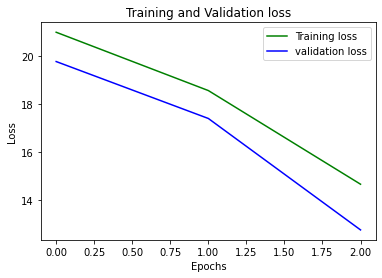

In [24]:
loss_train = np.array(history.history['loss'])
loss_val = np.array(history.history['val_loss'])
epochs = range(3)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()